In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
# from google.colab import drive
# drive.mount('/content/gdrive')


# 1. Data preprocessing

In [3]:
# data_df = pd.read_csv('gdrive/My Drive/MAP569-project/CreditTraining.csv')

data_df = pd.read_csv('https://raw.githubusercontent.com/jyyang5/MAP569-project/master/CreditTraining.csv')
label_df = data_df['Prod_Category'].tolist()
data_df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,NaN,D


Observations: there are categorical data, and we would to deal with that 

## 1.0. Types of data

In [4]:
clean_df = data_df.select_dtypes(exclude=['object']).copy()
cat_df = data_df.select_dtypes(include=['object']).copy()
cat_df.head()[:2]

,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Net_Annual_Income,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Prod_Closed_Date,Prod_Category
0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,36,C,14/02/2012,Sales,Owned,NaN,B
1,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,18,C,30/06/2011,Sales,Parents,NaN,G


In [5]:
temp_list = []
for ele in data_df['Net_Annual_Income'].tolist():
  if type(ele) is not float:
    temp_list.append(ele.replace(',','.'))
  else:
    temp_list.append(ele)

clean_df['Net_Annual_Income'] = temp_list
del cat_df['Net_Annual_Income']
clean_df[:2]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income
0,7440,0,3.0,1,1.0,1,36
1,573,0,0.0,12,2.0,1,18


In [6]:
cat_df.columns # all col names of categorical data 

Index(['Customer_Type', 'BirthDate', 'Customer_Open_Date', 'P_Client',
       'Educational_Level', 'Marital_Status', 'Prod_Sub_Category',
       'Prod_Decision_Date', 'Source', 'Type_Of_Residence', 'Prod_Closed_Date',
       'Prod_Category'],
      dtype='object')

In [7]:
cat_df['Marital_Status'].value_counts()

Married      4206
Single       1046
Widowed        64
Divorced       63
Separated       1
Name: Marital_Status, dtype: int64

## 1.1. Deal with categorical data excluding date

From all categorical datas ['Customer_Type', 'BirthDate', 'Customer_Open_Date', 'P_Client',
       'Educational_Level', 'Marital_Status', 'Net_Annual_Income',
       'Prod_Sub_Category', 'Prod_Decision_Date', 'Source',
       'Type_Of_Residence', 'Prod_Closed_Date', 'Prod_Category']

We first exclude ['BirthDate', 'Customer_Open_Date', 'Net_Annual_Income', 'Prod_Decision_Date']

We use 0-1 encoding for each category

In [8]:
for name in ['Customer_Type', 'P_Client',
            'Educational_Level', 'Marital_Status',
            'Prod_Sub_Category', 'Source',
            'Type_Of_Residence', 'Prod_Category']:
        print(cat_df[name].value_counts())

Non Existing Client    3369
Existing Client        2011
Name: Customer_Type, dtype: int64
NP_Client    4968
P_Client      412
Name: P_Client, dtype: int64
University           4785
Master/PhD            522
Diploma                58
Secondary or Less      15
Name: Educational_Level, dtype: int64
Married      4206
Single       1046
Widowed        64
Divorced       63
Separated       1
Name: Marital_Status, dtype: int64
C    4638
G     624
P     118
Name: Prod_Sub_Category, dtype: int64
Sales     4119
Branch    1261
Name: Source, dtype: int64
Owned       4791
Old rent     323
Parents      179
New rent      83
Company        4
Name: Type_Of_Residence, dtype: int64
B    3176
D     670
C     517
K     265
L     236
G     188
E     101
H      79
J      71
M      49
A      19
F       5
I       4
Name: Prod_Category, dtype: int64


Since 'Customer_Type', 'P_Client', 'Source' all have just two types so we restrict ourselves to binary variable.

$$
Customer\_Type = 
 \begin{cases}
1& \text{Existing Client} \\
0 & \text{otherwise}
\end{cases} \\
P\_Client = 
 \begin{cases}
1& \text{P Client} \\
0 & \text{NP Client}
\end{cases} \\
Source= 
 \begin{cases}
1& \text{Sales} \\
0 & \text{Brranch}
\end{cases}
$$



In [9]:
pd.get_dummies(cat_df[['Customer_Type', 'P_Client',
                       'Educational_Level', 'Marital_Status',
                       'Prod_Sub_Category', 'Source',
                       'Type_Of_Residence', 'Prod_Category']])[:2]

,Customer_Type_Existing Client,Customer_Type_Non Existing Client,P_Client_NP_Client,P_Client_P_Client,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,Educational_Level_University,Marital_Status_Divorced,Marital_Status_Married,...,Prod_Category_D,Prod_Category_E,Prod_Category_F,Prod_Category_G,Prod_Category_H,Prod_Category_I,Prod_Category_J,Prod_Category_K,Prod_Category_L,Prod_Category_M
0,0,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [10]:
clean_df1 = clean_df.join(pd.get_dummies(cat_df[['Customer_Type', 'P_Client',
                                                'Educational_Level', 'Marital_Status',
                                                'Prod_Sub_Category', 'Source',
                                                'Type_Of_Residence', 'Prod_Category']]))

clean_df1['Customer_Type'] = clean_df1['Customer_Type_Existing Client']
del clean_df1['Customer_Type_Existing Client']
del clean_df1['Customer_Type_Non Existing Client']

clean_df1['P_Client'] = clean_df1['P_Client_NP_Client']
del clean_df1['P_Client_NP_Client']
del clean_df1['P_Client_P_Client']

clean_df1['Source'] = clean_df1['Source_Branch']
del clean_df1['Source_Branch']
del clean_df1['Source_Sales']


clean_df1[:2]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,...,Prod_Category_G,Prod_Category_H,Prod_Category_I,Prod_Category_J,Prod_Category_K,Prod_Category_L,Prod_Category_M,Customer_Type,P_Client,Source
0,7440,0,3.0,1,1.0,1,36,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,573,0,0.0,12,2.0,1,18,0,0,0,...,1,0,0,0,0,0,0,1,0,0


## 1.2. Deal with years

['BirthDate', 'Customer_Open_Date', 'Net_Annual_Income', 'Prod_Decision_Date', 'Prod_Closed_Date']

- **Possible appraoches** 
    - Use duration
        - `Birth_Duration = Now - BirthDate` ('BirthDate'): assuming there is a distribution of credibility, just started working -> less credit, worked for a long time but not close to retirement -> high credit) 
        - `Customer_Open_Duration = Now - Customer_Open_Date` ('Customer_Open_Date'): usually longer the history is, the more royal the customer is
        - 'Prod_Closed_Date' - 'Prod_Decision_Date'
            - length of the product?: if product closed 
            - `Prod_not_closed = (Prod_closed != nan)`: dummy variable if the product is closed 'Prod_not_closed' = 0 if closed
            - `Prod_Decision_Duration = Now - Prod_Decision_Date`
            - `Prod_Closed_Duration = Now - Prod_Closed_Date`: inf if not closed
    - Set severals intervals 
        - 'Net_Annual_Income': 


In [11]:
type(cat_df['Prod_Closed_Date'].tolist()[3]) == float


False

In [12]:
# del clean_df1['BirthDate']
# del clean_df1['Customer_Open_Date'] 
# del clean_df1['Prod_Decision_Date']
# del clean_df1['Prod_closed']
# clean_df1['Prod_Decision_Duration'].tolist()[1].days

In [13]:
# duration: birth - now
temp_list = [(datetime.now().date() - datetime.strptime(datetime_str, '%d/%m/%Y').date()).days for datetime_str in cat_df['BirthDate'].tolist()]
clean_df1['Birth_Duration'] = temp_list

# duration: Customer_Open_Date
temp_list = [(datetime.now().date() - datetime.strptime(datetime_str, '%d/%m/%Y').date()).days for datetime_str in cat_df['Customer_Open_Date'].tolist()]
clean_df1['Customer_Open_Duration'] = temp_list

# dummy var: product closed = 1
temp_list = [int(type(ele) != float) for ele in cat_df['Prod_Closed_Date'].tolist()]
clean_df1['Prod_not_closed'] = temp_list

# duration: Prod_Decision_Date
temp_list = [(datetime.now().date() - datetime.strptime(datetime_str, '%d/%m/%Y').date()).days for datetime_str in cat_df['Prod_Decision_Date'].tolist()]
clean_df1['Prod_Decision_Duration'] = temp_list

# # duration: Prod_Closed_Date
# temp_list = [int(type(ele) != float) for ele in cat_df['Prod_Closed_Date'].tolist()]
# clean_df1['Prod_closed'] = temp_list


In [14]:
clean_df1[:2]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,...,Prod_Category_K,Prod_Category_L,Prod_Category_M,Customer_Type,P_Client,Source,Birth_Duration,Customer_Open_Duration,Prod_not_closed,Prod_Decision_Duration
0,7440,0,3.0,1,1.0,1,36,0,0,0,...,0,0,0,0,1,0,15591,2983,0,2982
1,573,0,0.0,12,2.0,1,18,0,0,0,...,0,0,0,1,0,0,16742,4087,0,3211


In [15]:
data_list = []
labels = []
for name in clean_df1.columns.values:
    if name is 'Id_Customer':
        pass
    elif name is 'Y':
        labels = clean_df1[name].tolist()
    else:
        data_list.append(clean_df1[name].tolist())

data_list = np.transpose(data_list)
data_list = np.array(data_list, dtype=np.float64)

## 1.3. Check data

## 1.3.1. Nan elemnts

In [49]:
for name in clean_df1.columns.values():
    if sum(np.isnan(clean_df1[name].tolist())) != 0:
        print()

TypeError: 'numpy.ndarray' object is not callable

In [17]:
# nan in firt and third col 
sum(np.isnan(clean_df1['Number_Of_Dependant'].tolist())), sum(np.isnan(clean_df1['Years_At_Business'].tolist()))


(2, 2)

In [18]:
clean_df1[np.isnan(clean_df1['Number_Of_Dependant'].tolist())]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,...,Prod_Category_K,Prod_Category_L,Prod_Category_M,Customer_Type,P_Client,Source,Birth_Duration,Customer_Open_Duration,Prod_not_closed,Prod_Decision_Duration
634,8953,1,NaN,21,1.0,2,33.6,0,0,0,...,0,0,0,1,0,1,10904,3494,1,2918
5045,9588,0,NaN,10,10.0,1,50,0,1,0,...,0,0,0,1,1,0,25486,5687,0,2910


In [19]:
clean_df1[np.isnan(clean_df1['Years_At_Business'].tolist())]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,...,Prod_Category_K,Prod_Category_L,Prod_Category_M,Customer_Type,P_Client,Source,Birth_Duration,Customer_Open_Duration,Prod_not_closed,Prod_Decision_Duration
1987,398,0,0.0,10,NaN,2,25,0,1,0,...,0,0,0,0,1,1,13119,3253,1,3246
2750,5882,0,0.0,2,NaN,1,108,0,0,0,...,0,0,0,0,1,1,14129,3044,0,3031


In [20]:
clean_df1[np.isnan(np.array(clean_df1['Net_Annual_Income'].tolist(), dtype=np.float64))]

,Id_Customer,Y,Number_Of_Dependant,Years_At_Residence,Years_At_Business,Nb_Of_Products,Net_Annual_Income,Educational_Level_Diploma,Educational_Level_Master/PhD,Educational_Level_Secondary or Less,...,Prod_Category_K,Prod_Category_L,Prod_Category_M,Customer_Type,P_Client,Source,Birth_Duration,Customer_Open_Duration,Prod_not_closed,Prod_Decision_Duration
1879,9399,0,0.0,10,10.0,1,NaN,0,0,0,...,0,0,0,0,1,0,18991,2919,1,2918
5144,9555,0,0.0,11,0.0,2,NaN,0,0,0,...,0,0,0,0,1,1,25292,2913,1,2910


##### Customer with nan 
- Years_At_Business
    - Id_Customer = 398, 5882	
- Number_Of_Dependant
    - Id_Customer = 8953, 9588	
- Net_Annual_Income
    - Id_Customer = 9399, 9555	



##### Potential approach:
- Delete the data (lose information)
- Replace value with the median 

In [21]:
clean_df2 = clean_df1.copy()

for name in ['Number_Of_Dependant', 'Years_At_Business', 'Net_Annual_Income']:
    temp_list = np.array(clean_df2[name].tolist(), dtype=np.float64)
    temp_list[np.isnan(temp_list)] = np.median(temp_list[~np.isnan(temp_list)])
    print(sum(np.isnan(temp_list)))
    clean_df2[name] = temp_list



0
0
0


(44, Index(['Id_Customer', 'Y', 'Number_Of_Dependant', 'Years_At_Residence',
        'Years_At_Business', 'Nb_Of_Products', 'Net_Annual_Income',
        'Educational_Level_Diploma', 'Educational_Level_Master/PhD',
        'Educational_Level_Secondary or Less', 'Educational_Level_University',
        'Marital_Status_Divorced', 'Marital_Status_Married',
        'Marital_Status_Separated', 'Marital_Status_Single',
        'Marital_Status_Widowed', 'Prod_Sub_Category_C', 'Prod_Sub_Category_G',
        'Prod_Sub_Category_P', 'Type_Of_Residence_Company',
        'Type_Of_Residence_New rent', 'Type_Of_Residence_Old rent',
        'Type_Of_Residence_Owned', 'Type_Of_Residence_Parents',
        'Prod_Category_A', 'Prod_Category_B', 'Prod_Category_C',
        'Prod_Category_D', 'Prod_Category_E', 'Prod_Category_F',
        'Prod_Category_G', 'Prod_Category_H', 'Prod_Category_I',
        'Prod_Category_J', 'Prod_Category_K', 'Prod_Category_L',
        'Prod_Category_M', 'Customer_Type', 'P_Client

In [22]:
train_df = clean_df2.copy()
del train_df['Y']
del train_df['Id_Customer']

labels = clean_df2['Y'].tolist()
data_list = []
for name in train_df.columns.values:
   data_list.append(train_df[name].tolist())

data_list = np.transpose(data_list)
data_list = np.array(data_list, dtype=np.float64)

'No nan:',sum(sum(np.isnan(data_list))) == 0, np.shape(train_df), np.shape(data_list)

('No nan:', True, (5380, 42), (5380, 42))

## 1.4. Split train and test data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.25, random_state=42)

np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)



## 1.5. Convert prediction labels 

This is a binary classification problem where we only have two labels 


In [24]:
print('-----------all-----------')
for i in set(labels):
    print(i,labels.count(i))
print('percentage of 1:', labels.count(1)/len(labels))


print('-----------train-----------')
for i in set(labels):
    print(i,y_train.count(i))
print('percentage of 1:', y_train.count(1)/len(y_train))

print('-----------test-----------')
for i in set(labels):
    print(i,y_test.count(i))
print('percentage of 1:', y_test.count(1)/len(y_test))


-----------all-----------
0 4987
1 393
percentage of 1: 0.07304832713754647
-----------train-----------
0 3751
1 284
percentage of 1: 0.07038413878562577
-----------test-----------
0 1236
1 109
percentage of 1: 0.08104089219330855


In [25]:
temp = labels
temp = np.array(temp)
temp[temp==1] = -1
temp[temp==0] = 1
temp[temp==-11] = 0


## 1.6. Evaluation metrics

| 		|     same clusters|   different clusters|
| :-------- | --------:| :------: |
| same class    |   TP  |  FN |
|different class|   FP  |  TN |
- $P(precision) = \frac{TP}{TP+FP}$ 
- $R(recall) = \frac{TP}{TP+FN}$ 
- $F_{\beta}= \frac{(\beta^2+1)PR}{\beta^2P+R}$



In [26]:
def convert_lables(labels):
    """ convert the input (0/1) labels to what is needed 
    return a binary label sequence 
    """
    labels = np.array(labels)
    if sum(labels) > len(labels)/2:
        labels[labels==1] = -1
        labels[labels==0] = 1
        labels[labels==-1] = 0
    return labels



def eval_metric(y_test, preds):
    """ 
    print the classification report 
    """
    
    preds = convert_lables(preds)
    print('confusion matrix')
    print(confusion_matrix(y_test, preds))
    print('\n')
    print('summary')
    print(classification_report(y_test, preds))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=2)
    metrics.auc(fpr, tpr)



# 2. Testing 
## 2.1. Deterministic Models
### 2.1.1. KNN


In [27]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
pred_KNN = neigh.predict(X_test)

eval_metric(y_test, pred_KNN)

confusion matrix
[[1230    6]
 [ 107    2]]


summary
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1236
           1       0.25      0.02      0.03       109

    accuracy                           0.92      1345
   macro avg       0.58      0.51      0.50      1345
weighted avg       0.87      0.92      0.88      1345



### 2.1.2. Kmeans

In [28]:
from sklearn.cluster import KMeans

neigh = KMeans(n_clusters=2)
neigh.fit(X_train, y_train)
pred_Kmeans = convert_lables(neigh.predict(X_test))

eval_metric(y_test, pred_Kmeans)

confusion matrix
[[694 542]
 [ 68  41]]


summary
              precision    recall  f1-score   support

           0       0.91      0.56      0.69      1236
           1       0.07      0.38      0.12       109

    accuracy                           0.55      1345
   macro avg       0.49      0.47      0.41      1345
weighted avg       0.84      0.55      0.65      1345



### 2.1.3. SVM

In [29]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
pred_SVM = convert_lables(clf.predict(X_test))

eval_metric(y_test, pred_SVM)

confusion matrix
[[1236    0]
 [ 109    0]]


summary
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1236
           1       0.00      0.00      0.00       109

    accuracy                           0.92      1345
   macro avg       0.46      0.50      0.48      1345
weighted avg       0.84      0.92      0.88      1345



## 2.2. Non-deterministic Models

### 2.2.1. Random forest 

In [30]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# random forest model 
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
pred_rfc = rfc.predict(X_test)

eval_metric(pred_rfc, y_test)

confusion matrix
[[1225   75]
 [  11   34]]


summary
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1300
           1       0.31      0.76      0.44        45

    accuracy                           0.94      1345
   macro avg       0.65      0.85      0.70      1345
weighted avg       0.97      0.94      0.95      1345



Feature ranking:
1. feature Prod_not_closed (0.220653)
2. feature Customer_Open_Duration (0.121884)
3. feature Birth_Duration (0.120023)
4. feature Prod_Decision_Duration (0.112951)
5. feature Years_At_Residence (0.067832)
6. feature Net_Annual_Income (0.059048)
7. feature Nb_Of_Products (0.044978)
8. feature Prod_Category_L (0.041043)
9. feature Years_At_Business (0.041031)
10. feature Number_Of_Dependant (0.034662)
11. feature Source (0.015936)
12. feature Customer_Type (0.013548)
13. feature Prod_Category_B (0.012911)
14. feature Marital_Status_Married (0.008935)
15. feature Marital_Status_Single (0.008561)
16. feature Prod_Category_D (0.007508)
17. feature Type_Of_Residence_Owned (0.007233)
18. feature Educational_Level_University (0.006253)
19. feature Educational_Level_Master/PhD (0.005791)
20. feature Prod_Category_K (0.005183)
21. feature Type_Of_Residence_Old rent (0.004840)
22. feature P_Client (0.004657)
23. feature Prod_Sub_Category_C (0.004630)
24. feature Prod_Category_H 

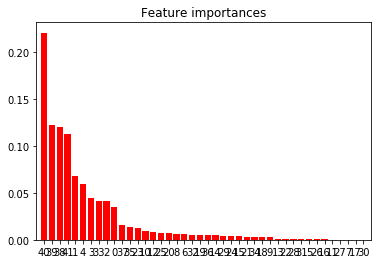

In [31]:
rfc_importances = rfc.feature_importances_
rfc_std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
rfc_indices = np.argsort(rfc_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train_df.columns.tolist()[rfc_indices[f]], rfc_importances[rfc_indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), rfc_importances[rfc_indices],
       color="r", yerr=rfc_std[rfc_indices], align="center")
plt.xticks(range(X_train.shape[1]), rfc_indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### 2.2.2. XGboost

In [32]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                            max_depth = 5, alpha = 20, n_estimators = 10) 

xg_reg.fit(X_train, y_train)
xg_preds = (xg_reg.predict(X_test)>=0.5)*1
eval_metric(xg_preds, y_test)

confusion matrix
[[1236  109]
 [   0    0]]


summary
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1345
           1       0.00      0.00      0.00         0

    accuracy                           0.92      1345
   macro avg       0.50      0.46      0.48      1345
weighted avg       1.00      0.92      0.96      1345



Feature ranking:
1. feature Prod_not_closed (0.608836)
2. feature Prod_Category_L (0.164004)
3. feature Nb_Of_Products (0.090894)
4. feature Customer_Type (0.017939)
5. feature Type_Of_Residence_Owned (0.011961)
6. feature Birth_Duration (0.011338)
7. feature Customer_Open_Duration (0.010421)
8. feature Prod_Category_B (0.010063)
9. feature Net_Annual_Income (0.009505)
10. feature Number_Of_Dependant (0.009361)
11. feature Source (0.008426)
12. feature Prod_Decision_Duration (0.007667)
13. feature Prod_Category_H (0.007109)
14. feature P_Client (0.006858)
15. feature Years_At_Residence (0.005415)
16. feature Prod_Category_M (0.004271)
17. feature Type_Of_Residence_New rent (0.003691)
18. feature Prod_Sub_Category_C (0.002972)
19. feature Years_At_Business (0.002819)
20. feature Prod_Category_G (0.002512)
21. feature Prod_Category_D (0.001961)
22. feature Marital_Status_Married (0.001011)
23. feature Marital_Status_Single (0.000966)
24. feature Marital_Status_Divorced (0.000000)
25. fea

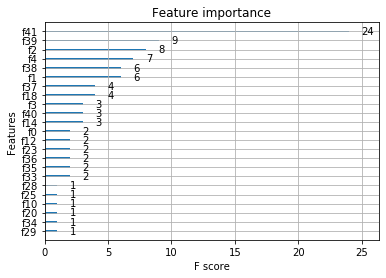

In [50]:
from xgboost import plot_importance
# plot feature importance

xg_importances = xg_reg.feature_importances_
xg_indices = np.argsort(xg_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train_df.columns.tolist()[xg_indices[f]], xg_importances[xg_indices[f]]))


plot_importance(xg_reg)
plt.show()

In [34]:
def test_deterministic(X_train, y_train):
    """ print the evaluation results of deterministic models
    """
    ################################
    # KNeighbors
    neigh = KNeighborsClassifier(n_neighbors=2)
    neigh.fit(X_train, y_train)
    pred_KNN = neigh.predict(X_test)

    print('----------------KNeighbors-------------------')
    eval_metric(y_test, pred_KNN)


    ################################
    # Kmeans
    neigh = KMeans(n_clusters=2)
    neigh.fit(X_train, y_train)
    pred_Kmeans = convert_lables(neigh.predict(X_test))

    print('----------------Kmeans-------------------')
    eval_metric(y_test, pred_Kmeans)

    ################################
    # SVM
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    pred_SVM = convert_lables(clf.predict(X_test))

    print('----------------SVM-------------------')
    eval_metric(y_test, pred_SVM)

In [35]:
def test_non_deterministic(X_train, y_train):
    """ print the evaluation results of non-deterministic models
    """
    ################################
    # random forest model 
    rfc = RandomForestClassifier()
    rfc.fit(X_train,y_train)
    # predictions
    pred_rfc = rfc.predict(X_test)

    print('----------------randomForest-------------------')
    eval_metric(pred_rfc, y_test)


    rfc_importances = rfc.feature_importances_
    rfc_std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
    rfc_indices = np.argsort(rfc_importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, train_df.columns.tolist()[rfc_indices[f]], rfc_importances[rfc_indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), rfc_importances[rfc_indices],
        color="r", yerr=rfc_std[rfc_indices], align="center")
    plt.xticks(range(X_train.shape[1]), rfc_indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()


    ################################
    # XGBoost
    xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                                max_depth = 5, alpha = 20, n_estimators = 10) 

    xg_reg.fit(X_train, y_train)
    xg_preds = (xg_reg.predict(X_test)>=0.5)*1
    print('----------------XGBoost-------------------')
    eval_metric(xg_preds, y_test)


    # plot feature importance
    xg_importances = xg_reg.feature_importances_
    xg_indices = np.argsort(xg_importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, train_df.columns.tolist()[xg_indices[f]], xg_importances[xg_indices[f]]))


    plot_importance(xg_reg)
    plt.show()


# 3. Deal with imbalanced data 
In Section 2, we did some experiments but find that even if the overall accurancy is high, the prediction result of clients with label=1 is not good. Especially with classifiers like SVM, the class with more samples (majority class) is favoured. We therefore resample the minority class to balance the train data and see how the result might improve. Since the size of the minority class is very small, we w.l.o.g. use Upsampling.   

## 3.1. Random sampling 
We resample the minority class to make the data balanced. 

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_rand, y_rand = ros.fit_resample(X_train, y_train)
for i in set(y_rand):
    print(i, y_rand.count(i))


0 3751
1 3751


In [37]:
test_deterministic(X_rand, y_rand)

----------------KNeighbors-------------------
confusion matrix
[[1153   83]
 [  98   11]]


summary
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1236
           1       0.12      0.10      0.11       109

    accuracy                           0.87      1345
   macro avg       0.52      0.52      0.52      1345
weighted avg       0.86      0.87      0.86      1345

----------------Kmeans-------------------
confusion matrix
[[676 560]
 [ 67  42]]


summary
              precision    recall  f1-score   support

           0       0.91      0.55      0.68      1236
           1       0.07      0.39      0.12       109

    accuracy                           0.53      1345
   macro avg       0.49      0.47      0.40      1345
weighted avg       0.84      0.53      0.64      1345

----------------SVM-------------------
confusion matrix
[[1236    0]
 [ 109    0]]


summary
              precision    recall  f1-score   support

      

----------------randomForest-------------------
confusion matrix
[[1203   60]
 [  33   49]]


summary
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1263
           1       0.45      0.60      0.51        82

    accuracy                           0.93      1345
   macro avg       0.71      0.78      0.74      1345
weighted avg       0.94      0.93      0.94      1345

Feature ranking:
1. feature Prod_not_closed (0.440277)
2. feature Customer_Open_Duration (0.087368)
3. feature Birth_Duration (0.079009)
4. feature Prod_Decision_Duration (0.071375)
5. feature Years_At_Residence (0.044783)
6. feature Net_Annual_Income (0.042914)
7. feature Prod_Category_L (0.042250)
8. feature Years_At_Business (0.034139)
9. feature Nb_Of_Products (0.029892)
10. feature Number_Of_Dependant (0.027094)
11. feature Source (0.010928)
12. feature Customer_Type (0.010407)
13. feature Prod_Category_B (0.008704)
14. feature Prod_Sub_Category_C (0.007145)
1

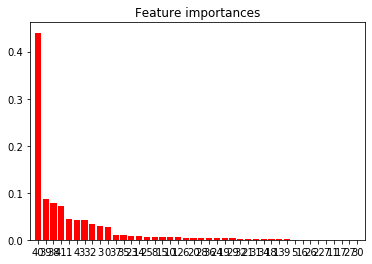

----------------XGBoost-------------------
confusion matrix
[[1102   19]
 [ 134   90]]


summary
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1121
           1       0.83      0.40      0.54       224

    accuracy                           0.89      1345
   macro avg       0.86      0.69      0.74      1345
weighted avg       0.88      0.89      0.87      1345

Feature ranking:
1. feature Prod_not_closed (0.769709)
2. feature Prod_Category_L (0.080432)
3. feature Nb_Of_Products (0.017693)
4. feature Prod_Sub_Category_C (0.013671)
5. feature Customer_Open_Duration (0.012533)
6. feature Prod_Category_J (0.009365)
7. feature Prod_Category_G (0.008652)
8. feature Prod_Category_D (0.007428)
9. feature Birth_Duration (0.007324)
10. feature Marital_Status_Single (0.006960)
11. feature Customer_Type (0.006654)
12. feature Number_Of_Dependant (0.006636)
13. feature Net_Annual_Income (0.006568)
14. feature Prod_Category_B (0.005633)
15.

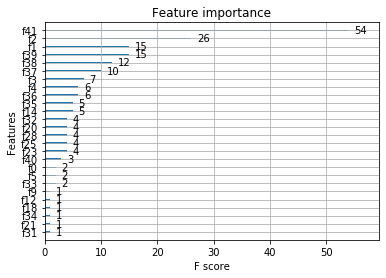

In [38]:
test_non_deterministic(X_rand, y_rand)

- Use resampling does not seem to affect much on the results of deterministic models
- There is a significant increase regarding the prediction accurany of clients with label = 1, $P_{\text{random forest}}$ increased from 0.28 to 0.44, although the false prediction of label = 1 increased. Meanwhile, XGBoost achieve $P_{\text{XGBoost}} = 0.83$ where the value before downsampling is 0.

## 3.2. Synthetic Minority Oversampling Technique (SMOTE)

In [44]:
from imblearn.over_sampling import SMOTE, ADASYN

X_SMOTE, y_SMOTE = SMOTE(random_state = 111).fit_resample(X_train, y_train)
for i in set(y_SMOTE):
    print(i, y_SMOTE.count(i))


0 3751
1 3751


In [40]:
test_deterministic(X_SMOTE, y_SMOTE)

----------------KNeighbors-------------------
confusion matrix
[[1027  209]
 [  87   22]]


summary
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1236
           1       0.10      0.20      0.13       109

    accuracy                           0.78      1345
   macro avg       0.51      0.52      0.50      1345
weighted avg       0.85      0.78      0.81      1345

----------------Kmeans-------------------
confusion matrix
[[675 561]
 [ 67  42]]


summary
              precision    recall  f1-score   support

           0       0.91      0.55      0.68      1236
           1       0.07      0.39      0.12       109

    accuracy                           0.53      1345
   macro avg       0.49      0.47      0.40      1345
weighted avg       0.84      0.53      0.64      1345

----------------SVM-------------------
confusion matrix
[[1234    2]
 [ 109    0]]


summary
              precision    recall  f1-score   support

      

----------------randomForest-------------------
confusion matrix
[[1198   60]
 [  38   49]]


summary
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1258
           1       0.45      0.56      0.50        87

    accuracy                           0.93      1345
   macro avg       0.71      0.76      0.73      1345
weighted avg       0.94      0.93      0.93      1345

Feature ranking:
1. feature Prod_not_closed (0.433792)
2. feature Prod_Category_B (0.063577)
3. feature Prod_Category_L (0.051982)
4. feature Customer_Open_Duration (0.041893)
5. feature Years_At_Business (0.039350)
6. feature Nb_Of_Products (0.035524)
7. feature Birth_Duration (0.034994)
8. feature Net_Annual_Income (0.031036)
9. feature Source (0.028526)
10. feature Number_Of_Dependant (0.027726)
11. feature Prod_Decision_Duration (0.027338)
12. feature Years_At_Residence (0.026902)
13. feature Prod_Category_D (0.024127)
14. feature Customer_Type (0.023315)
15. f

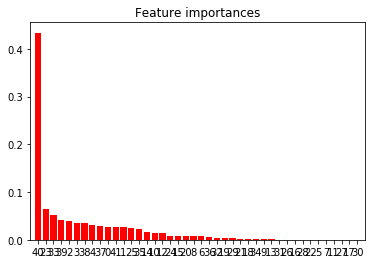

----------------XGBoost-------------------
confusion matrix
[[1205   67]
 [  31   42]]


summary
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1272
           1       0.39      0.58      0.46        73

    accuracy                           0.93      1345
   macro avg       0.68      0.76      0.71      1345
weighted avg       0.94      0.93      0.93      1345

Feature ranking:
1. feature Prod_not_closed (0.498526)
2. feature Prod_Category_B (0.120084)
3. feature Prod_Category_L (0.119727)
4. feature Years_At_Business (0.036722)
5. feature Nb_Of_Products (0.034706)
6. feature Source (0.032731)
7. feature Prod_Sub_Category_C (0.028540)
8. feature Prod_Category_D (0.027076)
9. feature Type_Of_Residence_Owned (0.015564)
10. feature Marital_Status_Married (0.015144)
11. feature P_Client (0.010000)
12. feature Customer_Type (0.009842)
13. feature Net_Annual_Income (0.009134)
14. feature Prod_Category_H (0.007024)
15. feature Custom

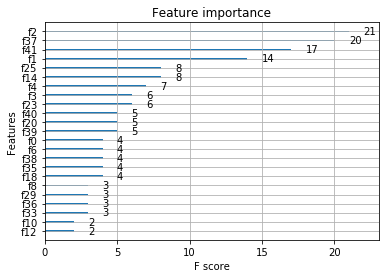

In [41]:
test_non_deterministic(X_SMOTE, y_SMOTE)

In [45]:
X_ADASYN, y_ADASYN = ADASYN(random_state = 111).fit_resample(X_train, y_train)
for i in set(y_ADASYN):
    print(i, y_ADASYN.count(i))


0 3751
1 3735


In [43]:
test_deterministic(X_ADASYN, y_ADASYN)

----------------KNeighbors-------------------
confusion matrix
[[1028  208]
 [  86   23]]


summary
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1236
           1       0.10      0.21      0.14       109

    accuracy                           0.78      1345
   macro avg       0.51      0.52      0.51      1345
weighted avg       0.86      0.78      0.81      1345

----------------Kmeans-------------------
confusion matrix
[[679 557]
 [ 67  42]]


summary
              precision    recall  f1-score   support

           0       0.91      0.55      0.69      1236
           1       0.07      0.39      0.12       109

    accuracy                           0.54      1345
   macro avg       0.49      0.47      0.40      1345
weighted avg       0.84      0.54      0.64      1345

----------------SVM-------------------
confusion matrix
[[1231    5]
 [ 109    0]]


summary
              precision    recall  f1-score   support

      

----------------randomForest-------------------
confusion matrix
[[1204   60]
 [  32   49]]


summary
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1264
           1       0.45      0.60      0.52        81

    accuracy                           0.93      1345
   macro avg       0.71      0.78      0.74      1345
weighted avg       0.94      0.93      0.94      1345

Feature ranking:
1. feature Prod_not_closed (0.391260)
2. feature Prod_Category_B (0.062980)
3. feature Prod_Category_L (0.061703)
4. feature Years_At_Business (0.047255)
5. feature Customer_Open_Duration (0.042071)
6. feature Net_Annual_Income (0.038862)
7. feature Source (0.038037)
8. feature Birth_Duration (0.036705)
9. feature Nb_Of_Products (0.033932)
10. feature Prod_Decision_Duration (0.030780)
11. feature Years_At_Residence (0.030273)
12. feature Number_Of_Dependant (0.029049)
13. feature Prod_Category_D (0.026314)
14. feature Customer_Type (0.025622)
15. f

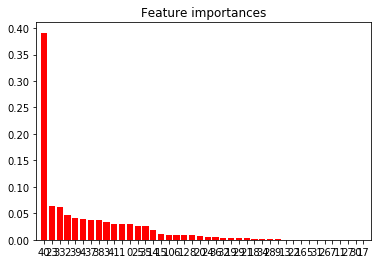

----------------XGBoost-------------------
confusion matrix
[[1205   64]
 [  31   45]]


summary
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1269
           1       0.41      0.59      0.49        76

    accuracy                           0.93      1345
   macro avg       0.69      0.77      0.72      1345
weighted avg       0.94      0.93      0.94      1345

Feature ranking:
1. feature Prod_not_closed (0.496478)
2. feature Prod_Category_L (0.092208)
3. feature Prod_Category_B (0.086895)
4. feature Years_At_Business (0.042822)
5. feature Nb_Of_Products (0.039329)
6. feature Prod_Category_D (0.037373)
7. feature Customer_Type (0.031318)
8. feature Prod_Sub_Category_C (0.028827)
9. feature Source (0.023197)
10. feature Marital_Status_Married (0.020732)
11. feature Customer_Open_Duration (0.018819)
12. feature Net_Annual_Income (0.016544)
13. feature Type_Of_Residence_Owned (0.012184)
14. feature Prod_Category_H (0.009295)
15. 

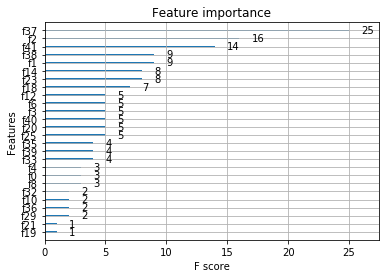

In [46]:
test_non_deterministic(X_ADASYN, y_ADASYN)

## 3.4. 